# 导入必要包

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader

# 定义绘图函数

In [17]:
# 定义一个名为 plot_series 的函数，用于绘制时间序列图
def plot_series(time, plot_series, format='-', start=0, end=None, label=None):
    # 使用 matplotlib 绘制时间序列图
    plt.plot(time[start:end], plot_series[start:end], format, label=label)
    plt.xlabel("Time")  # x轴标签
    plt.ylabel("Value")  # y轴标签
    if label:  # 如果提供了标签
        plt.legend(fontsize=14)  # 显示图例
    plt.grid(True)  # 显示网格
    plt.show()  # 显示图像


# 数据生成函数的编写

In [18]:
# 定义名为 trend 的函数，用于生成趋势数据
def trend(time, slope=0):
    """
    生成趋势数据。

    参数:
    time (list): 时间的列表。
    slope (float): 坡度，默认为0。
    """
    return (slope * time)

# 定义名为 whtie_noise 的函数，用于生成白噪声数据
def whtie_noise(time, std=1.0, seed=None):
    """
    生成白噪声数据。

    参数:
    time (list): 时间的列表。
    std (float): 标准差，默认为1.0。
    seed (int): 种子数，默认为None。
    """
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * std

# 定义名为 seasonal_pattern 的函数，用于生成季节性模式数据
def seasonal_pattern(season_time):
    """
    生成季节性模式数据。

    参数:
    season_time (list): 季节时间的列表。
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 定义名为 seasonality 的函数，用于生成季节性数据
def seasonality(time, period, amplitude=1, phase=0):
    """
    生成季节性数据。

    参数:
    time (list): 时间的列表。
    period (int): 周期数。
    amplitude (int): 振幅，默认为1。
    phase (int): 相位，默认为0。
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


# 数据集的生成
## 数据集的划分于batch的生成

In [19]:
def train_test_split(series, split_fraction=0.7):
    """
    将数据集划分为训练集和测试集。

    参数:
    series (list): 输入的时间序列数据。
    split_fraction (float): 划分的比例，默认为0.7。

    返回:
    train_set (list): 训练集数据。
    test_set (list): 测试集数据。
    """
    train_size = int(len(series) * split_fraction)
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set, test_set

# 定义名为 data_iter 的函数，用于将数据集划分为指定的 batch 大小
def data_iter(batch_size, features, labels):
    """
    将数据集划分为指定的 batch 大小。

    参数:
    batch_size (int): 每个 batch 的大小。
    features (Tensor): 特征集。
    labels (Tensor): 标签集。

    返回:
    features (Tensor): 选定的特征集。
    labels (Tensor): 选定的标签集。
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不满足一个 batch
        j = torch.LongTensor(indices[i:min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)


## 滑动窗口的实现

In [20]:
def data_process(train, test, window_size):
    """
    数据预处理函数，用于将数据集处理成适合训练和测试的形式。

    参数:
    train (list): 训练集数据。
    test (list): 测试集数据。
    window_size (int): 窗口大小。

    返回:
    train_feature (Tensor): 训练集特征数据。
    train_label (Tensor): 训练集标签数据。
    test_feature (Tensor): 测试集特征数据。
    test_label (Tensor): 测试集标签数据。
    """
    train_tensor = torch.from_numpy(train)  # 将训练集转换为张量
    train_windows_split = train_tensor.unfold(0, window_size, 1)  # 划分训练集窗口
    train_set = train_windows_split.numpy()  # 转换为 NumPy 数组

    test_tensor = torch.from_numpy(test)  # 将测试集转换为张量
    test_windows_split = test_tensor.unfold(0, window_size, 1)  # 划分测试集窗口
    test_set = test_windows_split.numpy()  # 转换为 NumPy 数组

    # 将训练集短序列打乱
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2 = np.array(train_temp1)

    test_temp1 = test_set.tolist()
    # random.shuffle(test_temp1)
    test_temp2 = np.array(test_temp1)

    # 将短序列划分为 feature 和 label
    train_feature_array = train_temp2[:, :window_size - 1]
    train_label_array = train_temp2[:, window_size - 1:]

    test_feature_array = test_temp2[:, :window_size - 1]
    test_label_array = test_temp2[:, window_size - 1:]

    # 将 np.array 转为 tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)

    # 扩展数据维度，符合 CNN 输入
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label


# 生成虚拟数据集

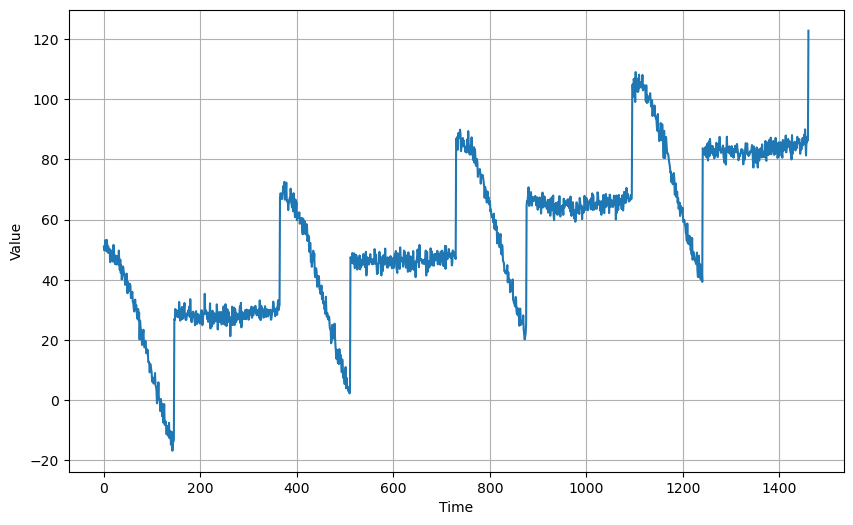

In [21]:


time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 2

# 生成时间序列数据
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + whtie_noise(time, noise_level, seed=42)
series = series.astype(np.double)

# 绘制时间序列图
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


# 数据处理

In [22]:
import torch
import random
from torch.utils.data import Dataset, DataLoader

split_prop = 0.7  # 划分比例
train, test = train_test_split(series, split_prop)  # 划分训练集和测试集
windows_size = 6  # 窗口大小

# 调用 data_process 函数进行数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, windows_size)

batch_size = 128  # 批处理大小


# 定义神经网络

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # 导入PyTorch中的神经网络模块

# 定义卷积模型
class ConvModel(nn.Module):  # 继承自nn.Module类
   def __init__(self):  # 初始化函数
       super(ConvModel, self).__init__()  # 调用父类构造函数
       self.conv1 = nn.Sequential(  # 第一个卷积层
           nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # 1维卷积层
           nn.ReLU(inplace=True)  # ReLU激活函数
       )
       self.conv2 = nn.Sequential(  # 第二个卷积层
           nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),  # 1维卷积层
           nn.ReLU(inplace=True)  # ReLU激活函数
       )
       self.fc1 = nn.Linear(64, 128)  # 全连接层1
       self.fc2 = nn.Linear(128, 1)  # 全连接层2

   def forward(self, x):  # 前向传播函数
       out = self.conv1(x)  # 第一层卷积
       out = F.avg_pool1d(out, 2)  # 平均池化
       out = self.conv2(out)  # 第二层卷积
       out = F.avg_pool1d(out, 2)  # 平均池化层
       out = out.squeeze()  # 压缩张量的维度
       out = self.fc1(out)  # 第一层全连接
       out = self.fc2(out)  # 第二层全连接
       return out  # 返回输出结果


In [24]:
import torch  # 导入PyTorch模块
from torch.utils.data import Dataset, DataLoader  # 从PyTorch中导入数据集和数据加载器

# 划分训练集和测试集的比例
split_prop = 0.7
# 划分训练集和测试集
train, test = train_test_split(series, split_prop)
# 滑动窗口的大小
windows_size = 6

# 调用data_process函数进行数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, windows_size)

# 定义批量大小
batch_size = 128

# 设置模型训练参数
lr = 0.01  # 学习率
epoch = 500  # 迭代次数

# 初始化模型和优化器
net = ConvModel()  # 创建卷积模型
opt = torch.optim.Adam(net.parameters(), lr=lr)  # 使用Adam优化器进行优化
for param in net.parameters():  # 遍历模型参数
    torch.nn.init.normal_(param, mean=0, std=0.01)  # 以正态分布初始化模型参数

# 定义损失函数
def loss(x, y):  # 定义损失函数
    return (net(x) - y) ** 2 / 2

train_loss = []  # 训练集的损失
test_loss = []  # 测试集的损失

# 进行模型训练
for epoch_num in range(epoch):  # 迭代训练模型
    train_list = []  # 训练集损失列表
    test_list = []  # 测试集损失列表
    for x, y in data_iter(batch_size, train_feature, train_label):  # 遍历训练集数据
        x = x.to(torch.float32)  # 将输入数据转换为32位浮点型
        y = y.to(torch.float32)  # 将标签数据转换为32位浮点型
        l = loss(x, y).mean()  # 计算损失的均值
        if opt is not None:  # 如果优化器不为空
            opt.zero_grad()  # 清除梯度
        elif params is not None and params[0].grad is not None:  # 如果参数不为空且参数的梯度不为空
            for param in params:  # 遍历参数
                param.grad.data.zero_()  # 清零梯度数据
        l.backward()  # 反向传播
        opt.step()  # 优化器进行参数更新

        train_list.append(l.item())  # 将损失值添加到训练集损失列表中
    for x, y in data_iter(batch_size, test_feature, test_label):  # 遍历测试集数据
        x = x.to(torch.float32)  # 将输入数据转换为32位浮点型
        y = y.to(torch.float32)  # 将标签数据转换为32位浮点型
        l = loss(x, y).mean()  # 计算损失的均值
        test_list.append(l.item())  # 将损失值添加到测试集损失列表中
    test_loss.append(np.mean(test_list))  # 计算并添加测试集损失的平均值
    train_loss.append(np.mean(train_list))  # 计算


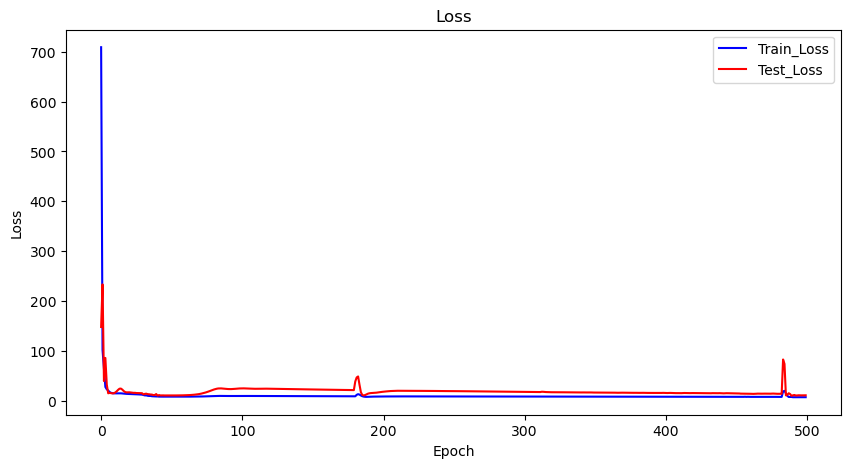

In [28]:
from matplotlib import pyplot as plt

# 创建一个绘图的图形
plt.figure(figsize=(10, 5))

# 用蓝色和红色线条分别绘制训练损失和测试损失
plt.plot(range(len(train_loss)), train_loss, 'b-', label="Train_Loss")
plt.plot(range(len(train_loss)), test_loss, 'r-', label="Test_Loss")

# 添加 x 轴和 y 轴的标签
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 设置图形的标题
plt.title('Loss')

# 添加图例来区分两条线
plt.legend()

# 展示图形
plt.show()


# 模型预测

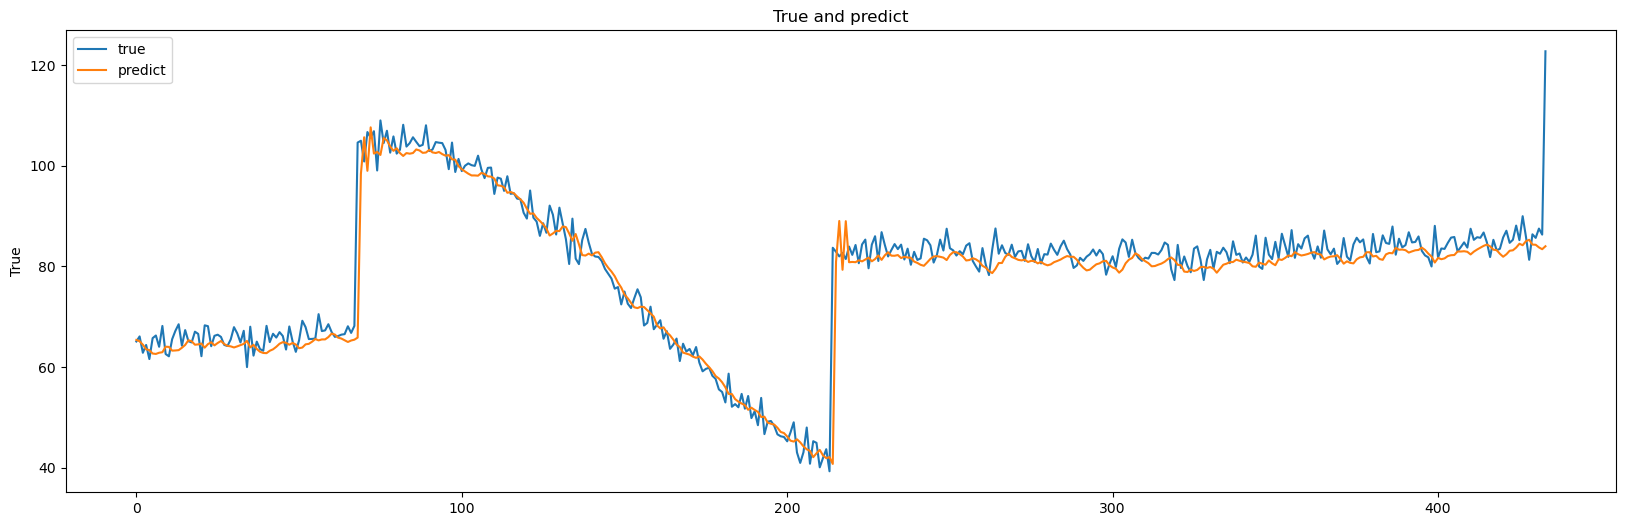

In [27]:
# 创建一个空的列表来存储测试集的预测值
test_predict = []

# 将数据集的拆分点计算为整个序列长度乘以拆分比例
split_point = int(split_prop * int(series.size))

# 测试集的真实序列
test_true = test

# 使用训练好的模型对测试集特征进行预测并将结果转换为 Python 列表形式
test_predict = net(test_feature.to(torch.float32)).squeeze().tolist()

# 创建一个图形来可视化真实值和预测值
plt.figure(figsize=(20, 6))
plt.plot(test_label, label='true')
plt.plot(test_predict, label='predict')
plt.ylabel('True')
plt.title('True and predict')
plt.legend()
plt.show()
